In [29]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import numpy as np
from scipy.signal import butter, lfilter, freqz

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,  # base font size
        "axes.labelsize": 18,  # x/y labels
        "axes.titlesize": 18,  # subplot titles
        "xtick.labelsize": 14,  # x tick labels
        "ytick.labelsize": 14,  # y tick labels
        "legend.fontsize": 14,  # legends
        "figure.titlesize": 16,  # suptitle
    }
)

shotno = 50377

# adjust base URL or file-path as needed
base_url = f"http://golem.fjfi.cvut.cz/shots/{shotno}/Diagnostics/"

files = {
    "Hα": "U_Halpha.csv",
    "Hβ": "U_Hbeta.csv",
    "He I": "U_HeI.csv",
    "Whole": "U_whole.csv",
}

In [2]:
data = {}
while True:
    try:
        for label, fname in files.items():
            url = base_url + "FastSpectrometry" + fname
            # assume comma delimiter; skip header lines if needed
            df = pd.read_csv(url)
            data[label] = df
            print(f"{label}: loaded {df.shape[0]} rows, columns = {list(df.columns)}")
        break  # exit loop if successful
    except urllib.error.HTTPError as e:
        print(f"Failed to load data for shot {shotno}, retrying...")
        time.sleep(2)
        continue


Hα: loaded 3999 rows, columns = ['    0', '0.003']
Hβ: loaded 3999 rows, columns = ['    0', '0.003']
He I: loaded 3999 rows, columns = ['    0', '0.004']
Whole: loaded 3999 rows, columns = ['    0', '0.002']


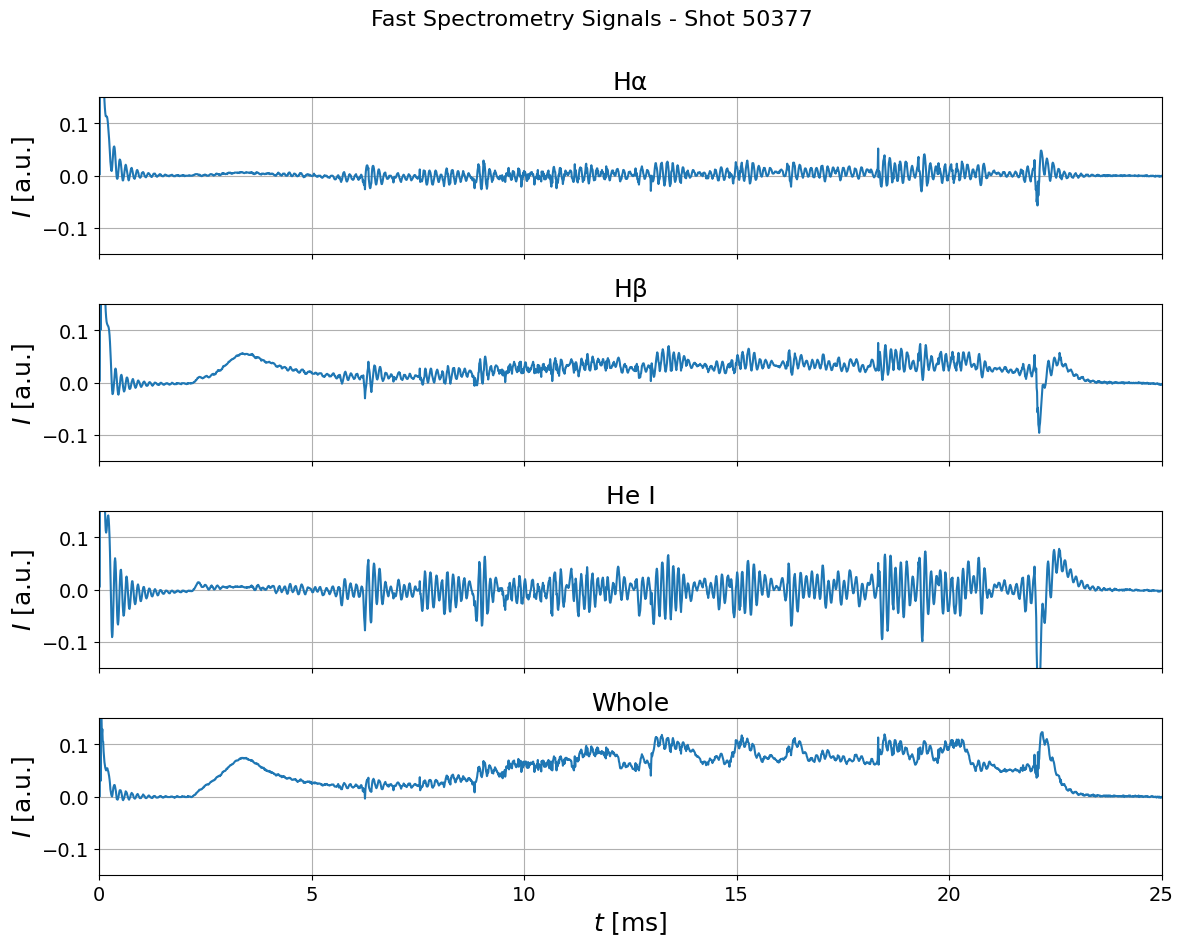

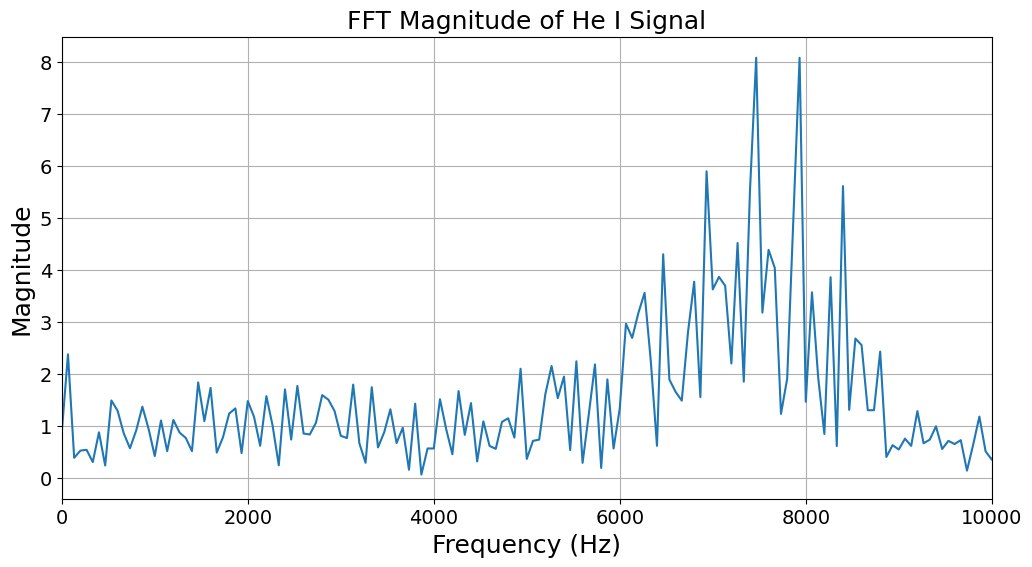

In [73]:
# One figure, four stacked subplots (share X for alignment)
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(12, 10), sharey=True)

noise_coeff = 0
noise = np.array(data["He I"].iloc[:, 1])
noise = np.roll(noise, -1)  # Shift noise data for better comparison

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

for ax, (label, df) in zip(axes, data.items()):
    t = df.iloc[:, 0] * 1e3  # convert to ms
    u = df.iloc[:, 1]
    ax.plot(t, u - noise*noise_coeff, label=label)
    # ax.plot(t, butter_lowpass_filter(u, 1000, 100e3), label=label)
    # ax.plot(t, u, color="gray", alpha=0.5, label="Noise (Whole)", marker=".")
    ax.set_ylabel(r"$I$ [a.u.]")
    ax.grid(True)
    ax.set_title(label)
    ax.set_xlim(0, 25)
    ax.set_ylim(-0.15, 0.15)
    # ax.set_yscale('log')

# Label only the bottom axis with X label
# Use LaTeX-style mathtext for x-axis label
axes[-1].set_xlabel(r"$t$ [ms]")

# Figure-level title (fontsize controlled by rcParams figure.titlesize)
# Move it slightly closer to the subplots
fig.suptitle(f"Fast Spectrometry Signals - Shot {shotno}", y=0.975)

# Adjust layout; raise the top of the axes area to sit closer to the suptitle
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show the single figure with all four subplots
plt.show()

# Compute FFT for He I signal
he_i_signal = data["He I"].iloc[:, 1].values[500:2000]
fft_he_i = np.fft.fft(he_i_signal)
freqs = np.fft.fftfreq(len(he_i_signal), d=1e-5)

# Plot the magnitude of the FFT
plt.figure(figsize=(12, 6))
plt.plot(freqs[:len(freqs)//2], np.abs(fft_he_i)[:len(freqs)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,10000)
plt.title('FFT Magnitude of He I Signal')
plt.grid(True)
plt.show()

In [34]:
import h5py
import tempfile
import os

# URL of the H5 file
h5_url = base_url + "MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5"

# Create a temporary file to store the downloaded H5 data
with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
    temp_path = temp_file.name
    
    # Download the H5 file
    try:
        urllib.request.urlretrieve(h5_url, temp_path)
        print(f"Successfully downloaded H5 file to {temp_path}")
        
        # Now open the local H5 file
        Spectra = h5py.File(temp_path, 'r')["Spectra"]
        Wavelengths = h5py.File(temp_path, 'r')["Wavelengths"][1:]
        
    except urllib.error.HTTPError as e:
        print(f"Failed to download H5 file: {e}")
    except Exception as e:
        print(f"Error processing H5 file: {e}")

Successfully downloaded H5 file to /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpw0f96amf.h5


Found 40 wavelength points between 651-671 nm
Wavelength range: 652.10 - 669.66 nm
Computed 20 integrated intensity values


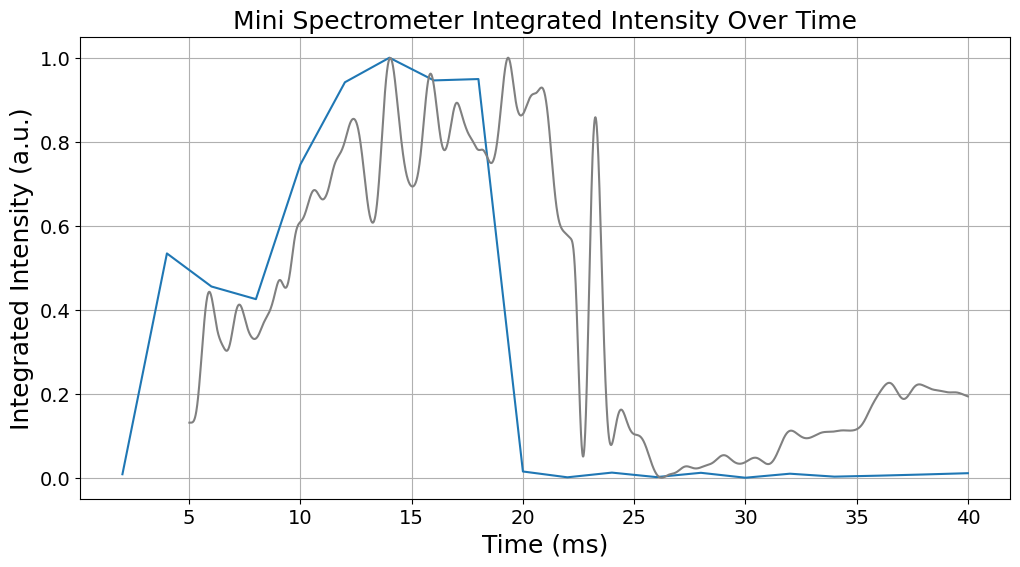

In [71]:
# Find indexes where wavelength is between 651 and 671 nm
wavelength_mask = (Wavelengths >= 652) & (Wavelengths <= 670)
wavelength_indexes = np.where(wavelength_mask)[0]

print(f"Found {len(wavelength_indexes)} wavelength points between 651-671 nm")
print(f"Wavelength range: {Wavelengths[wavelength_indexes][0]:.2f} - {Wavelengths[wavelength_indexes][-1]:.2f} nm")

# Create time array and integrate intensity for each spectrum
mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
mini_spectrometer_intensity = []

for i in range(len(Spectra)):
    # Extract intensity values at the selected wavelength indexes
    spectrum_slice = Spectra[i][wavelength_indexes]
    # Integrate using trapezoidal rule
    total_intensity = np.trapz(spectrum_slice, Wavelengths[wavelength_indexes])
    mini_spectrometer_intensity.append(total_intensity)

mini_spectrometer_intensity = np.array(mini_spectrometer_intensity)
print(f"Computed {len(mini_spectrometer_intensity)} integrated intensity values")

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Plot mini spectrometer integrated intensity over time
plt.figure(figsize=(12, 6))
plt.plot(mini_spectrometer_t, normalize(mini_spectrometer_intensity), label='Integrated Intensity (651-671 nm)')
# Add gray plot of Hβ signal passed through butter_lowpass_filter
t_hb = data['Hβ'].iloc[:, 0][500:] * 1e3  # convert to ms
u_hb = data['Hβ'].iloc[:, 1][500:]
filtered_hb = butter_lowpass_filter(u_hb, 1000, 100e3)
plt.plot(t_hb, normalize(filtered_hb), color='gray', label='Hβ Filtered')
plt.xlabel('Time (ms)')
plt.ylabel('Integrated Intensity (a.u.)')
plt.title('Mini Spectrometer Integrated Intensity Over Time')
plt.grid(True)
plt.show()